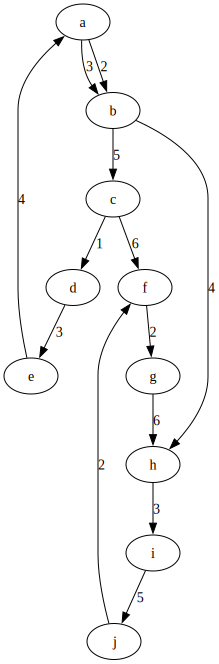

In [17]:
# Importação do grafo
from networkx import nx_agraph
from graphviz import Source

# Carregar o grafo usando NetworkX
graph = nx_agraph.read_dot('./graphs/graph4.dot')

# Imprime na tela
graph_dot = nx_agraph.to_agraph(graph)
source = Source(graph_dot.to_string())
source

## Algoritmo de Prim
Implemente o algoritmo de Prim, para calcular a árvore geradora mínima
de um grafo dado. Utilize um heap binário como lista de prioridade.
Utilize o algoritmo da Seção 21.2 do livro do Cormen, 4a edição, como
referência.

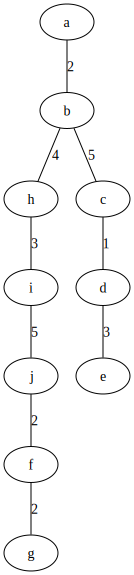

In [18]:
import heapq
from networkx import Graph, has_path

queue = []
result_tree = Graph()
result_tree.add_node(list(graph.nodes)[0])
added_nodes = set()

def edge_already_used(edge):
    return result_tree.has_node(edge[0]) and result_tree.has_node(edge[1])

def edge_already_added(edge):
    return queue.count((int(edge[2]["label"]), edge[:2])) > 0

def forms_cycle(edge):
    if result_tree.has_node(edge[0]) and result_tree.has_node(edge[1]):
        return has_path(result_tree, edge[0], edge[1])
    return False

def add_node_to_queue(node):
    for edge in graph.edges(node, data=True):
        if not edge_already_used(edge) and not edge_already_added(edge):
            weight = int(edge[2]["label"])
            heapq.heappush(queue, (weight, edge[:2]))
    added_nodes.add(node)

while len(result_tree.edges) != len(graph.nodes) - 1:
    
    node_to_add_to_queue = set(result_tree.nodes) - added_nodes
    if node_to_add_to_queue:
        add_node_to_queue(node_to_add_to_queue.pop())

    if queue:
        weight, edge = heapq.heappop(queue)
        if not forms_cycle(edge):
            result_tree.add_edge(*edge, label=weight)


# Imprime na tela
result_tree_dot = nx_agraph.to_agraph(result_tree)  
source = Source(result_tree_dot.to_string())
source

## Algoritmo de Bellman-Ford
Implemente o algoritmo de Bellman-Ford, que calcula os caminhos mínimos de um vértice para todos os vértices de um grafo. Utilize o algoritmo
da Seção 22.1 do livro do Cormen, 4a edição, como referência.

In [19]:
import pandas

def parse_weight(attr):
    if attr is None:
        return 1.0
    if isinstance(attr, dict):
        val = attr.get('weight', attr.get('label', 1))
    else:
        val = attr
    try:
        return float(val)
    except Exception:
        return 1.0

def bellman_ford(graph, source):

    def extract_edges():
        if graph.is_multigraph():
            return [(u, v, parse_weight(data)) for u, v, k, data in graph.edges(keys=True, data=True)]
        else:
            return [(u, v, parse_weight(data)) for u, v, data in graph.edges(data=True)]

    def relax_all(distances, predecessor, edges):
        for u, v, w in edges:
            if distances[u] != float('inf') and distances[v] > distances[u] + w:
                distances[v] = distances[u] + w
                predecessor[v] = u

    distances = {v: float('inf') for v in graph.nodes()}
    predecessor = {v: None for v in graph.nodes()}
    distances[source] = 0.0
    edges = extract_edges()
    n = graph.number_of_nodes()

    for _ in range(n - 1):
        relax_all(distances, predecessor, edges)

    return distances, predecessor

def reconstruct_path(predecessor, source, target):
    if target not in predecessor or source not in predecessor:
        return None
    path = []
    current = target
    while current is not None:
        path.append(current)
        if current == source:
            break
        current = predecessor[current]
    if path[-1] != source:
        return None
    path.reverse()
    return path

source_node = list(graph.nodes())[0] 
print(f"Executando Bellman-Ford a partir do nó: {source_node}")

try:
    distances, predecessor = bellman_ford(graph, source_node)
except ValueError as e:
    print("Erro:", e)
else:
    caminhos = []
    for node in graph.nodes():
        if node == source_node:
            caminhos.append(f"{source_node}")
        else:
            p = reconstruct_path(predecessor, source_node, node)
            caminhos.append(" -> ".join(p) if p is not None else "-")

    dataframe = pandas.DataFrame({
        "Vértice": list(distances.keys()),
        "Distância mínima": [distances[node] if distances[node] != float('inf') else "∞" for node in distances],
        "Caminho (da fonte)": caminhos,
    })

    display(dataframe)


Executando Bellman-Ford a partir do nó: a


,Vértice,Distância mínima,Caminho (da fonte)
0,a,0.0,a
1,b,2.0,a -> b
2,c,7.0,a -> b -> c
3,d,8.0,a -> b -> c -> d
4,e,11.0,a -> b -> c -> d -> e
5,f,13.0,a -> b -> c -> f
6,g,15.0,a -> b -> c -> f -> g
7,h,6.0,a -> b -> h
8,i,9.0,a -> b -> h -> i
9,j,14.0,a -> b -> h -> i -> j


## Algoritmo de Floyd-Warshall
Implemente o algoritmo de Floyd-Warshall, que calcula os caminhos mínimos de todos os vértices para todos os vértices de um grafo. Utilize o
algoritmo da Seção 23.2 do livro do Cormen, 4a edição, como referência.

In [20]:
import networkx as nx
import pandas as pd
import math

def floyd_warshall(graph: nx.DiGraph):
    nodes = list(graph.nodes())

    distance = pd.DataFrame(
        data=math.inf,
        index=nodes,
        columns=nodes
    )

    for node in nodes:
        distance.loc[node, node] = 0

    for source, target, data in graph.edges(data=True):
        weight = float(data.get("label", 1))
        distance.loc[source, target] = min(distance.loc[source, target], weight)

    for k in nodes:
        new_distance = distance.copy()
        for i in nodes:
            for j in nodes:
                new_distance.loc[i, j] = min(
                    distance.loc[i, j],
                    distance.loc[i, k] + distance.loc[k, j]
                )
        distance = new_distance
    return distance


distance_matrix = floyd_warshall(graph)
print("Matriz de distâncias mínimas (Floyd–Warshall):")
display(distance_matrix)

Matriz de distâncias mínimas (Floyd–Warshall):


,a,b,c,d,e,f,g,h,i,j
a,0.0,2.0,7.0,8.0,11.0,13.0,15.0,6.0,9.0,14.0
b,13.0,0.0,5.0,6.0,9.0,11.0,13.0,4.0,7.0,12.0
c,8.0,10.0,0.0,1.0,4.0,6.0,8.0,14.0,17.0,22.0
d,7.0,9.0,14.0,0.0,3.0,20.0,22.0,13.0,16.0,21.0
e,4.0,6.0,11.0,12.0,0.0,17.0,19.0,10.0,13.0,18.0
f,inf,inf,inf,inf,inf,0.0,2.0,8.0,11.0,16.0
g,inf,inf,inf,inf,inf,16.0,0.0,6.0,9.0,14.0
h,inf,inf,inf,inf,inf,10.0,12.0,0.0,3.0,8.0
i,inf,inf,inf,inf,inf,7.0,9.0,15.0,0.0,5.0
j,inf,inf,inf,inf,inf,2.0,4.0,10.0,13.0,0.0
